# Importações

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier


In [20]:
# Carregar o dataset
df = pd.read_parquet('../dataset/yelp_academic_dataset_business_cleaned.parquet')

# Seleção de colunas
cols = [
    'stars', 'review_count', 'latitude', 'longitude',
    'Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'RestaurantsPriceRange2'
]
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

# Remover valores nulos na coluna alvo
df = df.dropna(subset=['RestaurantsPriceRange2'])

# Combinar classes 3 e 4
df['RestaurantsPriceRange2'] = df['RestaurantsPriceRange2'].replace({4: 3}) - 1

# Separar features e target
X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


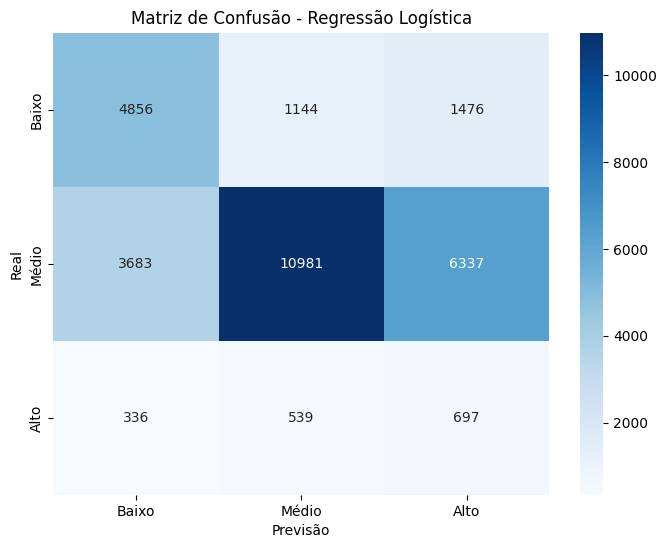

Relatório de Classificação (Regressão Logística):
              precision    recall  f1-score   support

           0       0.55      0.65      0.59      7476
           1       0.87      0.52      0.65     21001
           2       0.08      0.44      0.14      1572

    accuracy                           0.55     30049
   macro avg       0.50      0.54      0.46     30049
weighted avg       0.75      0.55      0.61     30049



In [ ]:
# Pipeline com SMOTE e Regressão Logística
pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)))
])

pipeline_lr.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

print("Relatório de Classificação (Regressão Logística):")
print(classification_report(y_test, y_pred_lr))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


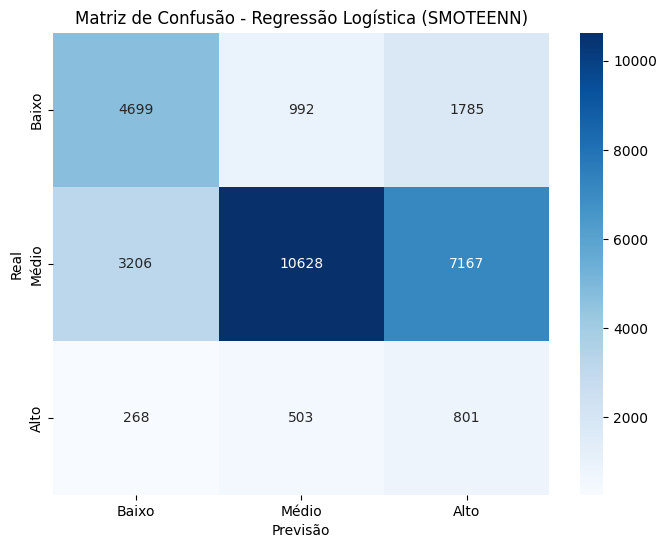

Relatório de Classificação (Regressão Logística com SMOTEENN):
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      7476
           1       0.88      0.51      0.64     21001
           2       0.08      0.51      0.14      1572

    accuracy                           0.54     30049
   macro avg       0.51      0.55      0.46     30049
weighted avg       0.76      0.54      0.61     30049



In [ ]:
# Pipeline com SMOTEENN e Regressão Logística
pipeline_lr_smoteenn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),  # SMOTEENN aqui
    ('classifier', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)))
])

pipeline_lr_smoteenn.fit(X_train, y_train)

y_pred_lr_smoteenn = pipeline_lr_smoteenn.predict(X_test)

cm_lr_smoteenn = confusion_matrix(y_test, y_pred_lr_smoteenn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (SMOTEENN)')
plt.show()

print("Relatório de Classificação (Regressão Logística com SMOTEENN):")
print(classification_report(y_test, y_pred_lr_smoteenn))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


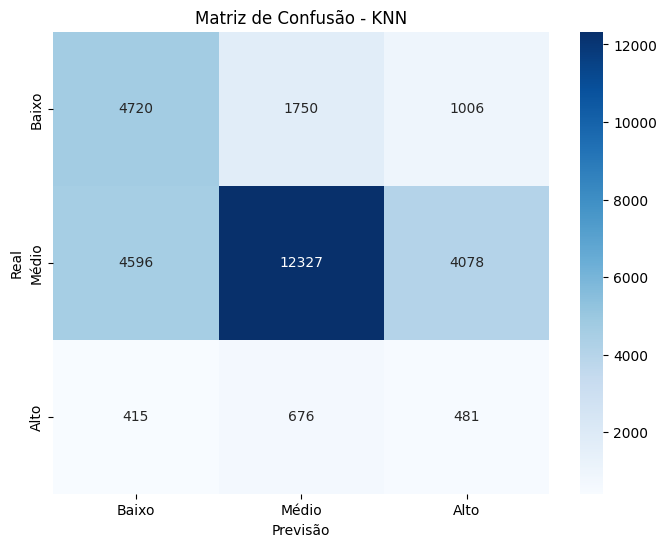

Relatório de Classificação (KNN):
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      7476
           1       0.84      0.59      0.69     21001
           2       0.09      0.31      0.13      1572

    accuracy                           0.58     30049
   macro avg       0.47      0.51      0.46     30049
weighted avg       0.71      0.58      0.63     30049



In [ ]:
# Pipeline com SMOTE e KNN
pipeline_knn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)

y_pred_knn = pipeline_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - KNN')
plt.show()

print("Relatório de Classificação (KNN):")
print(classification_report(y_test, y_pred_knn))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


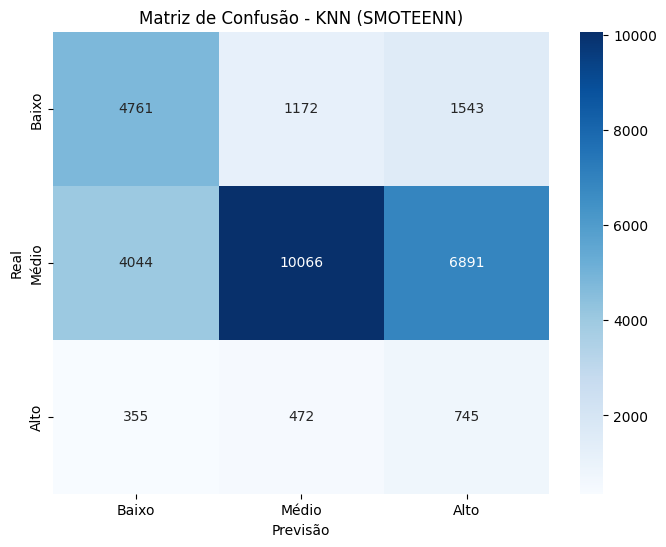

Relatório de Classificação (KNN com SMOTEENN):
              precision    recall  f1-score   support

           0       0.52      0.64      0.57      7476
           1       0.86      0.48      0.62     21001
           2       0.08      0.47      0.14      1572

    accuracy                           0.52     30049
   macro avg       0.49      0.53      0.44     30049
weighted avg       0.73      0.52      0.58     30049



In [ ]:
# Pipeline com SMOTEENN e KNN
pipeline_knn_smoteenn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_smoteenn.fit(X_train, y_train)

y_pred_knn_smoteenn = pipeline_knn_smoteenn.predict(X_test)

cm_knn_smoteenn = confusion_matrix(y_test, y_pred_knn_smoteenn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - KNN (SMOTEENN)')
plt.show()

print("Relatório de Classificação (KNN com SMOTEENN):")
print(classification_report(y_test, y_pred_knn_smoteenn))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


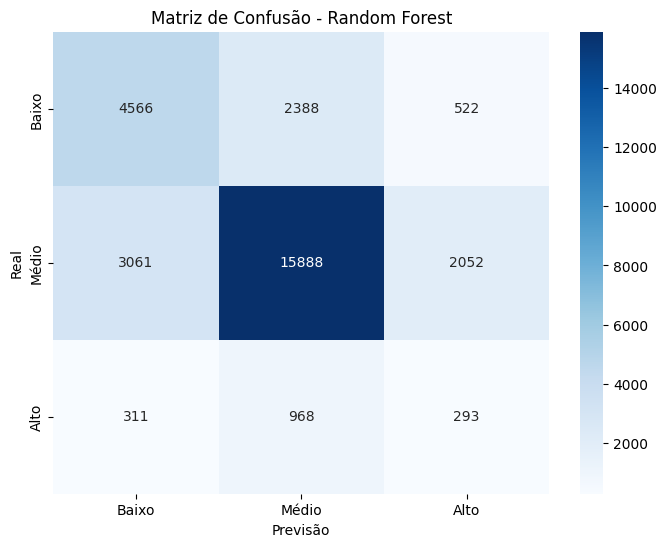

Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       0.58      0.61      0.59      7476
           1       0.83      0.76      0.79     21001
           2       0.10      0.19      0.13      1572

    accuracy                           0.69     30049
   macro avg       0.50      0.52      0.50     30049
weighted avg       0.73      0.69      0.71     30049



In [ ]:
# Pipeline com SMOTE e Random Forest
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


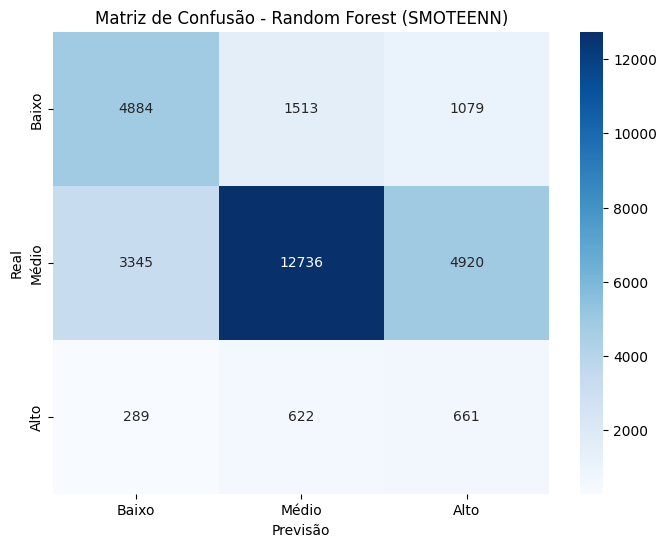

Relatório de Classificação (Random Forest com SMOTEENN):
              precision    recall  f1-score   support

           0       0.57      0.65      0.61      7476
           1       0.86      0.61      0.71     21001
           2       0.10      0.42      0.16      1572

    accuracy                           0.61     30049
   macro avg       0.51      0.56      0.49     30049
weighted avg       0.75      0.61      0.66     30049



In [ ]:
# Pipeline com SMOTEENN e Random Forest
pipeline_rf_smoteenn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),  # SMOTEENN aqui
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf_smoteenn.fit(X_train, y_train)

y_pred_rf_smoteenn = pipeline_rf_smoteenn.predict(X_test)

cm_rf_smoteenn = confusion_matrix(y_test, y_pred_rf_smoteenn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest (SMOTEENN)')
plt.show()

print("Relatório de Classificação (Random Forest com SMOTEENN):")
print(classification_report(y_test, y_pred_rf_smoteenn))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


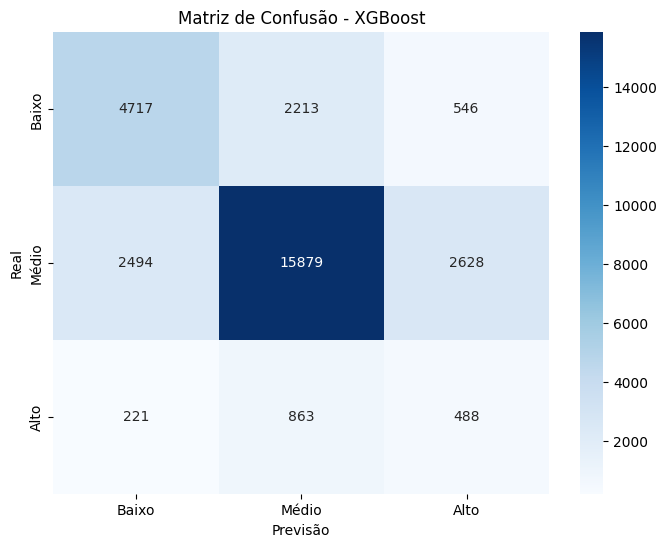

Relatório de Classificação (XGBoost):
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      7476
           1       0.84      0.76      0.79     21001
           2       0.13      0.31      0.19      1572

    accuracy                           0.70     30049
   macro avg       0.54      0.57      0.54     30049
weighted avg       0.75      0.70      0.72     30049



In [ ]:
# Pipeline com SMOTE e XGBoost
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

print("Relatório de Classificação (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


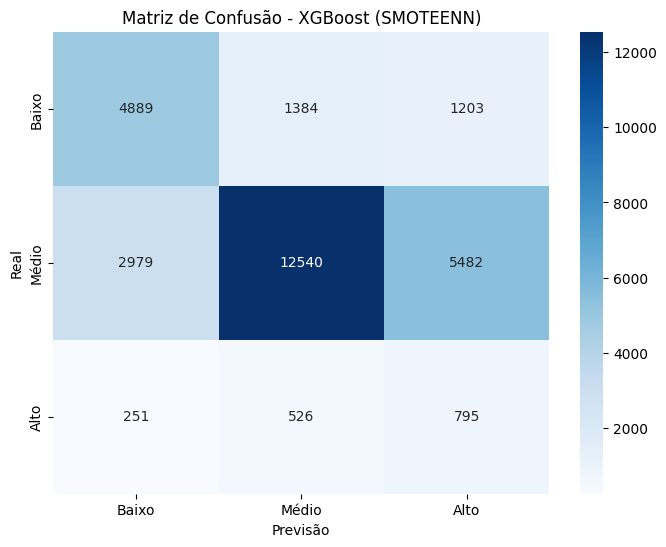

Relatório de Classificação (XGBoost com SMOTEENN):
              precision    recall  f1-score   support

           0       0.60      0.65      0.63      7476
           1       0.87      0.60      0.71     21001
           2       0.11      0.51      0.18      1572

    accuracy                           0.61     30049
   macro avg       0.53      0.59      0.50     30049
weighted avg       0.76      0.61      0.66     30049



In [ ]:
# Pipeline com SMOTEENN e XGBoost
pipeline_xgb_smoteenn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),  # SMOTEENN aqui
    ('classifier', XGBClassifier(random_state=42))
])

pipeline_xgb_smoteenn.fit(X_train, y_train)

y_pred_xgb_smoteenn = pipeline_xgb_smoteenn.predict(X_test)

cm_xgb_smoteenn = confusion_matrix(y_test, y_pred_xgb_smoteenn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_smoteenn, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost (SMOTEENN)')
plt.show()

print("Relatório de Classificação (XGBoost com SMOTEENN):")
print(classification_report(y_test, y_pred_xgb_smoteenn))

In [ ]:
# Comparação SMOTE
results = {
    'Regressão Logística': classification_report(y_test, y_pred_lr, output_dict=True),
    'KNN': classification_report(y_test, y_pred_knn, output_dict=True),
    'Random Forest': classification_report(y_test, y_pred_rf, output_dict=True),
    'XGBoost': classification_report(y_test, y_pred_xgb, output_dict=True)
}

for model, report in results.items():
    print(f"Resultados para {model}:")
    print(pd.DataFrame(report).transpose())
    print("\n")

Resultados para Regressão Logística:
              precision    recall  f1-score       support
0              0.547155  0.649545  0.593970   7476.000000
1              0.867104  0.522880  0.652369  21001.000000
2              0.081904  0.443384  0.138266   1572.000000
accuracy       0.550235  0.550235  0.550235      0.550235
macro avg      0.498721  0.538603  0.461535  30049.000000
weighted avg   0.746425  0.550235  0.610945  30049.000000


Resultados para KNN:
              precision    recall  f1-score       support
0              0.485048  0.631354  0.548614   7476.000000
1              0.835559  0.586972  0.689545  21001.000000
2              0.086433  0.305980  0.134791   1572.000000
accuracy       0.583314  0.583314  0.583314      0.583314
macro avg      0.469013  0.508102  0.457650  30049.000000
weighted avg   0.709164  0.583314  0.625461  30049.000000


Resultados para Random Forest:
              precision    recall  f1-score       support
0              0.575208  0.610754  0.

In [ ]:
# Comparação SMOTEENN
results = {
    'Regressão Logística (SMOTEENN)': classification_report(y_test, y_pred_lr_smoteenn, output_dict=True),
    'KNN (SMOTEENN)': classification_report(y_test, y_pred_knn_smoteenn, output_dict=True),
    'Random Forest (SMOTEENN)': classification_report(y_test, y_pred_rf_smoteenn, output_dict=True),
    'XGBoost (SMOTEENN)': classification_report(y_test, y_pred_xgb_smoteenn, output_dict=True)
}

for model, report in results.items():
    print(f"Resultados para {model}:")
    print(pd.DataFrame(report).transpose())
    print("\n")

Resultados para Regressão Logística (SMOTEENN):
              precision    recall  f1-score       support
0              0.574942  0.628545  0.600550   7476.000000
1              0.876681  0.506071  0.641710  21001.000000
2              0.082129  0.509542  0.141457   1572.000000
accuracy       0.536723  0.536723  0.536723      0.536723
macro avg      0.511250  0.548053  0.461239  30049.000000
weighted avg   0.760043  0.536723  0.605299  30049.000000


Resultados para KNN (SMOTEENN):
              precision    recall  f1-score      support
0              0.519760  0.636838  0.572373   7476.00000
1              0.859607  0.479311  0.615450  21001.00000
2              0.081164  0.473919  0.138592   1572.00000
accuracy       0.518220  0.518220  0.518220      0.51822
macro avg      0.486844  0.530022  0.442138  30049.00000
weighted avg   0.734331  0.518220  0.579786  30049.00000


Resultados para Random Forest (SMOTEENN):
              precision    recall  f1-score       support
0          

In [ ]:
# Ajuste de threshold para melhorar a precisão da classe 2 (originalmente 3)
def adjust_threshold(model, X_test, y_test, target_class, threshold):
    y_probs = model.predict_proba(X_test)
    y_pred = (y_probs[:, target_class] >= threshold).astype(int)
    print(f"\nRelatório de Classificação (Classe {target_class} com threshold = {threshold}):")
    print(classification_report((y_test == target_class).astype(int), y_pred))

adjust_threshold(pipeline_xgb, X_test, y_test, target_class=2, threshold=0.5)  # Ajuste o threshold conforme necessário


Relatório de Classificação (Classe 2 com threshold = 0.5):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     28477
           1       0.17      0.19      0.18      1572

    accuracy                           0.91     30049
   macro avg       0.56      0.57      0.56     30049
weighted avg       0.91      0.91      0.91     30049



c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [ ]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)
    
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i+1} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend()
    plt.show()
    
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
    
    plt.figure(figsize=(10, 5))
    for i in range(3):
        plt.plot(recall[i], precision[i], label=f'Classe {i+1} (AUC = {pr_auc[i]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall - {model_name}')
    plt.legend()
    plt.show()

Plotando curvas para Regressão Logística (SMOTE)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


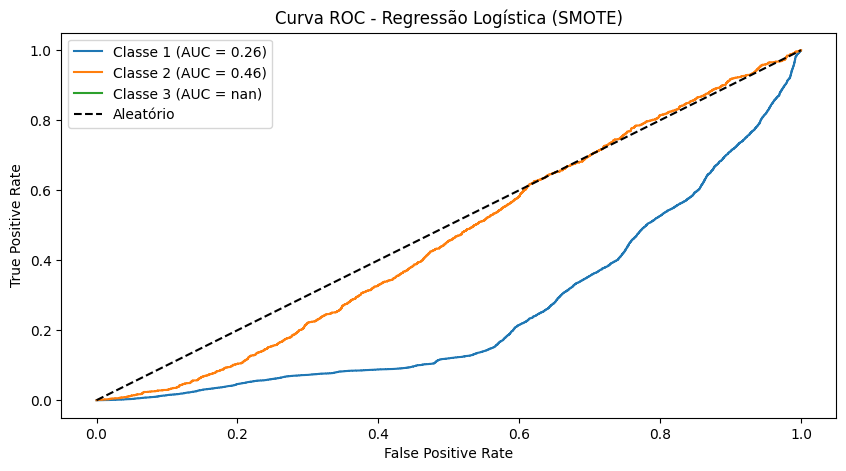

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


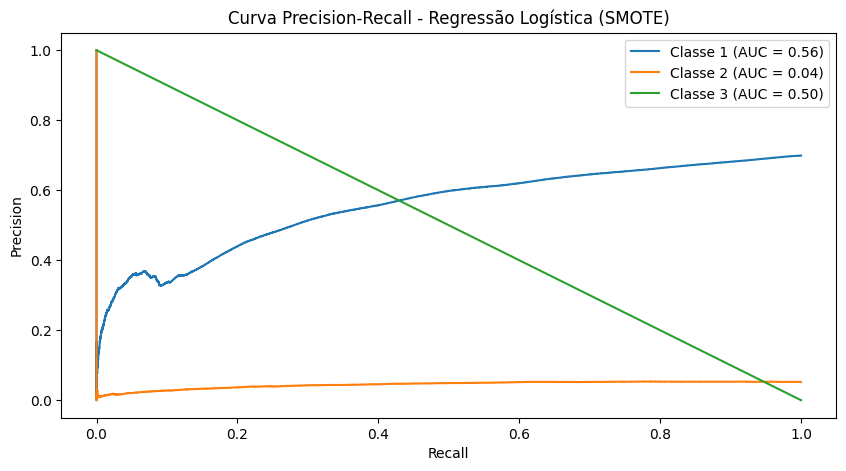

Plotando curvas para Regressão Logística (SMOTEENN)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


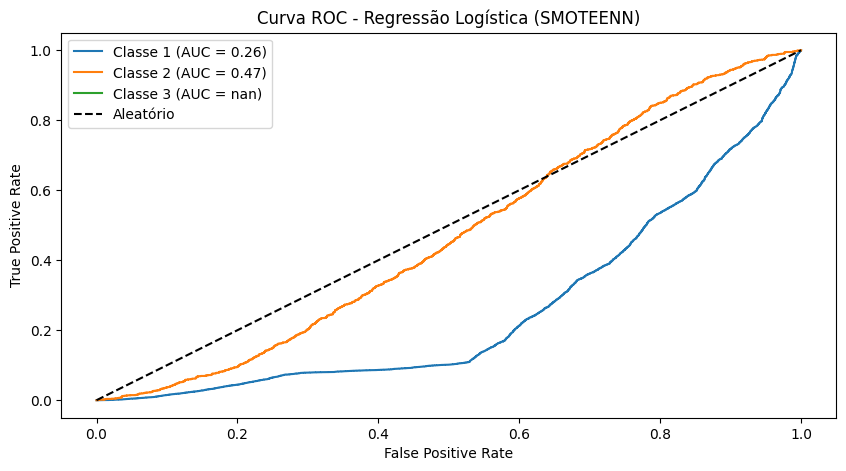

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


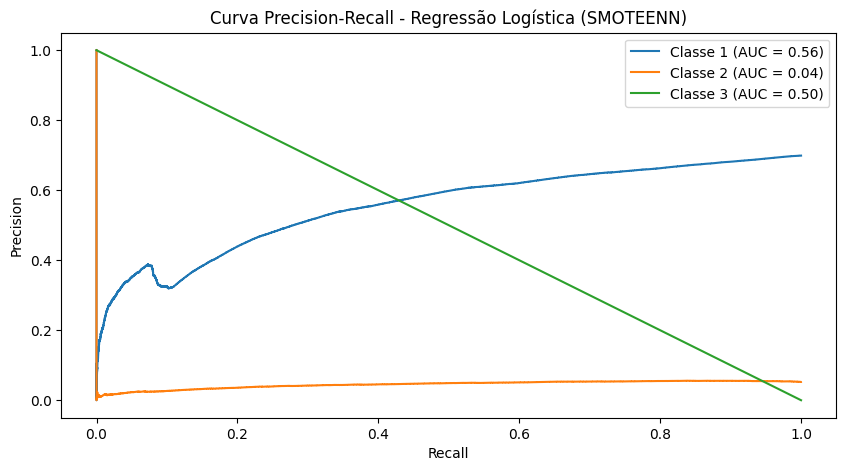

Plotando curvas para KNN (SMOTE)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


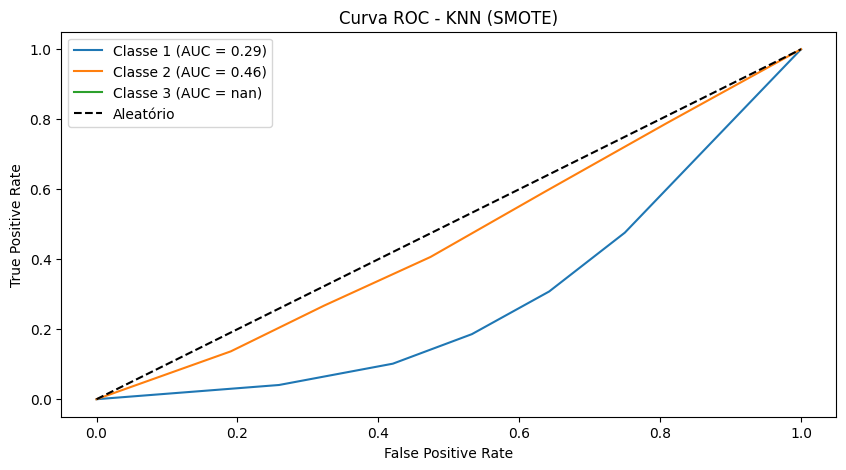

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


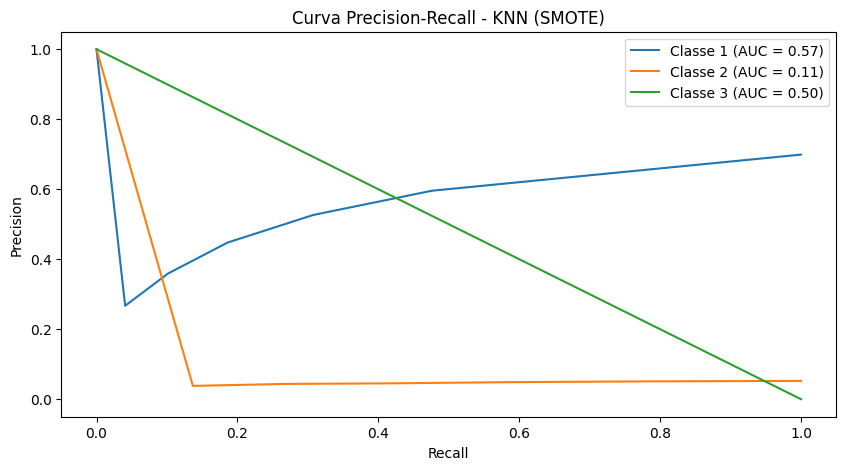

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Plotando curvas para KNN (SMOTEENN)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


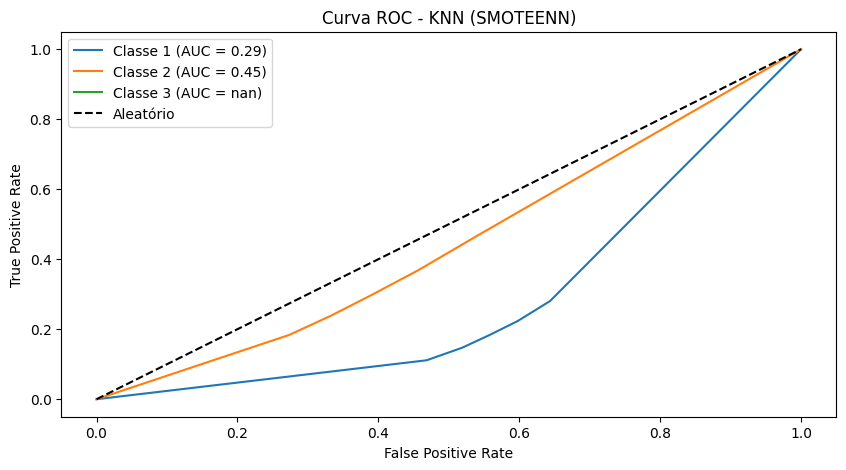

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


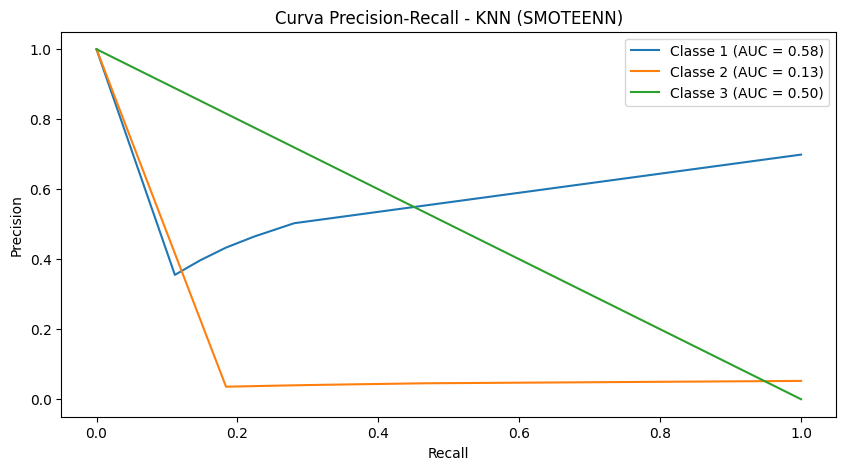

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Plotando curvas para Random Forest (SMOTE)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


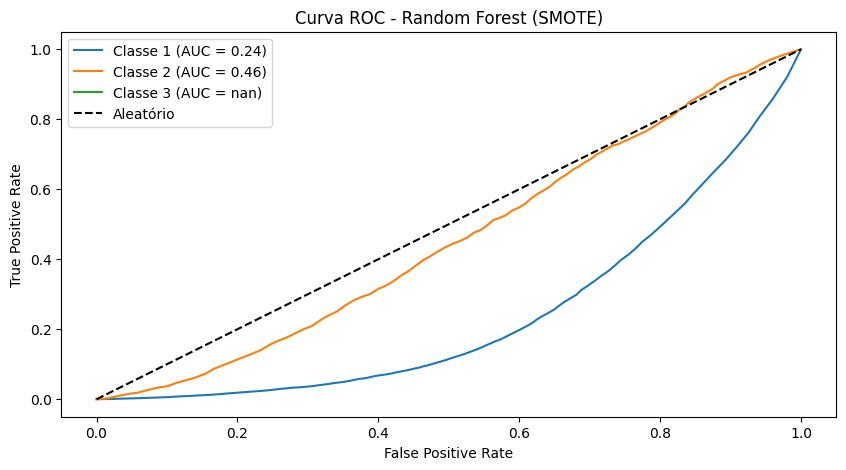

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


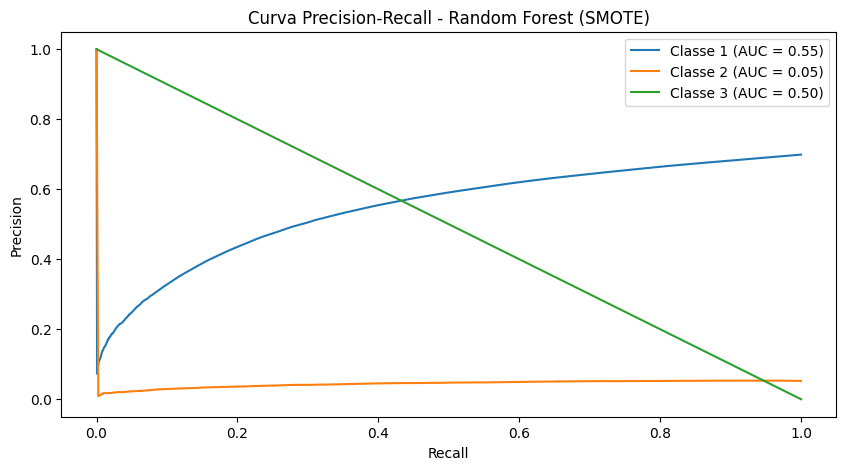

Plotando curvas para Random Forest (SMOTEENN)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


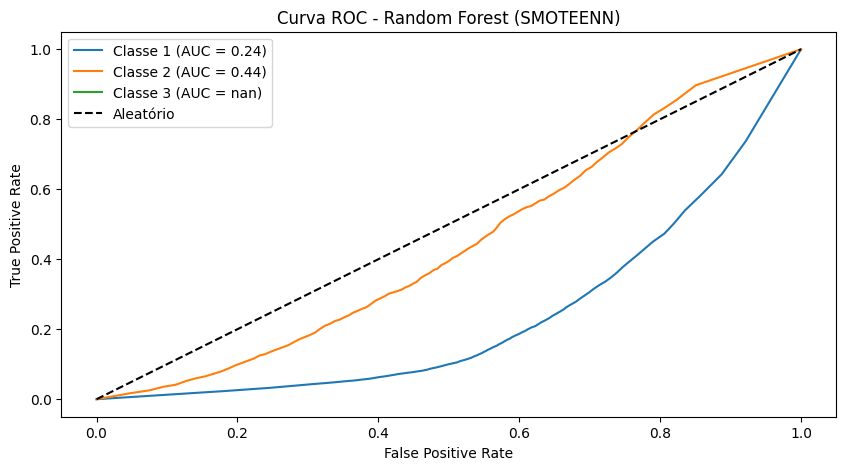

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


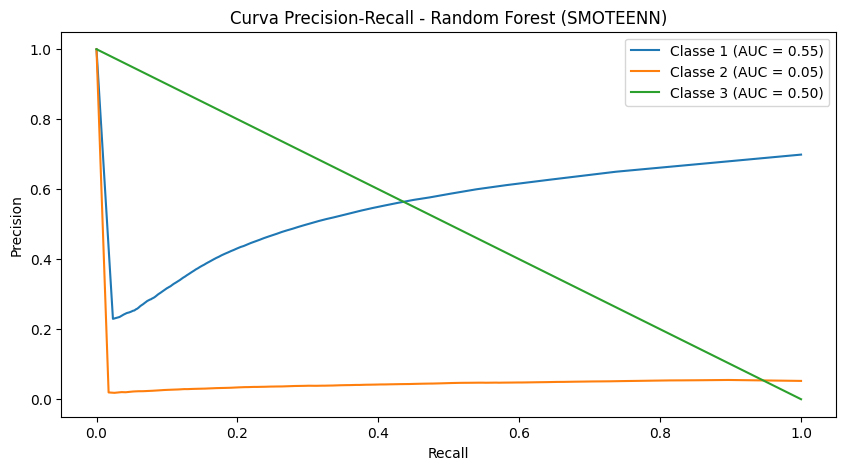

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Plotando curvas para XGBoost (SMOTE)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


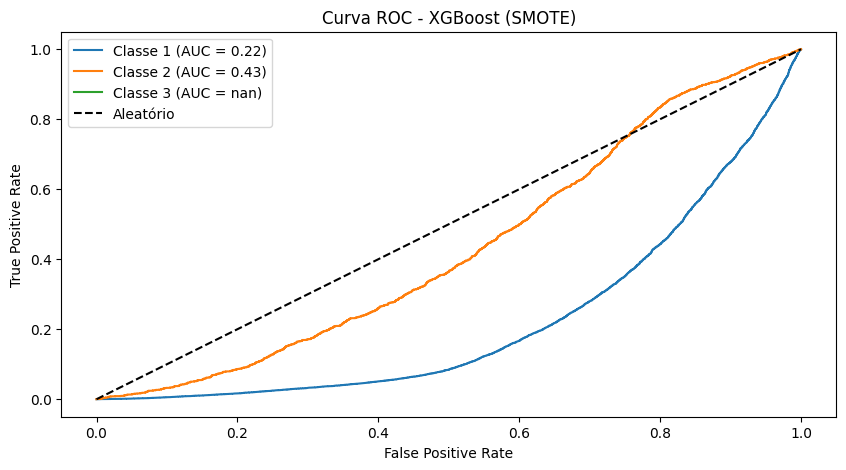

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


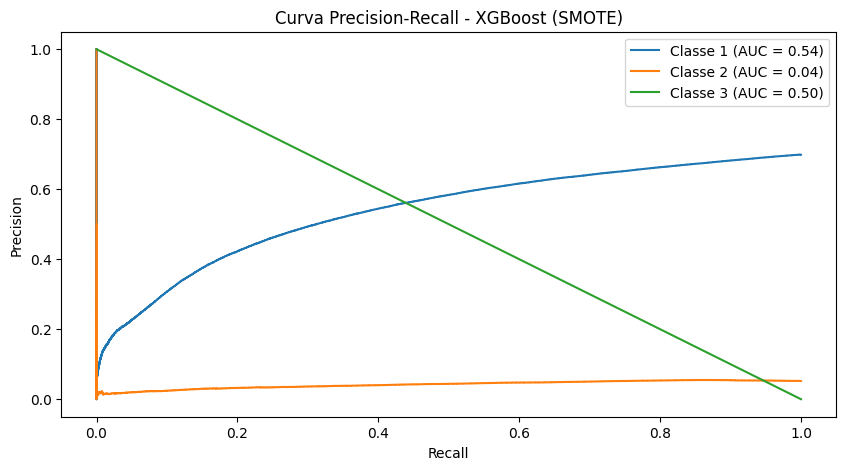

Plotando curvas para XGBoost (SMOTEENN)...


c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


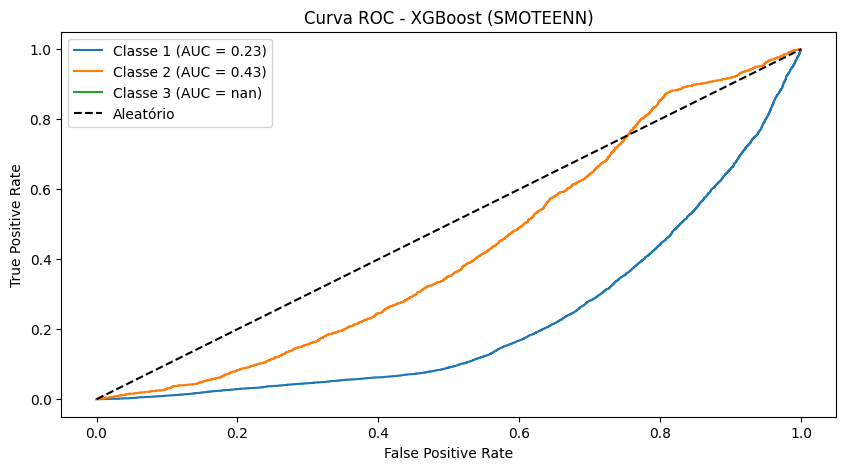

c:\Users\Plugify\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


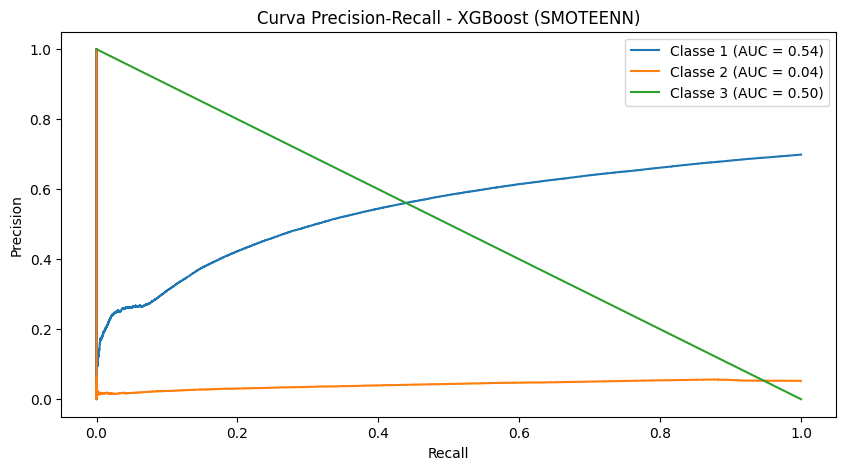

In [ ]:
models = {
    'Regressão Logística (SMOTE)': pipeline_lr,
    'Regressão Logística (SMOTEENN)': pipeline_lr_smoteenn,
    'KNN (SMOTE)': pipeline_knn,
    'KNN (SMOTEENN)': pipeline_knn_smoteenn,
    'Random Forest (SMOTE)': pipeline_rf,
    'Random Forest (SMOTEENN)': pipeline_rf_smoteenn,
    'XGBoost (SMOTE)': pipeline_xgb,
    'XGBoost (SMOTEENN)': pipeline_xgb_smoteenn
}

for model_name, model in models.items():
    print(f"Plotando curvas para {model_name}...")
    plot_roc_pr_curves(model, X_test, y_test, model_name)